<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity


In this notebook we are going to make an introduction of image similarity.



In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../image_classification") # to get the utilities of image classication (utils_ic)
sys.path.append("..") # to get the utilities of image similarity (utils_is)

from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *
from torch.cuda import get_device_name
from tqdm import tqdm_notebook

from utils_ic.gpu_utils import gpu_info
from utils_ic.datasets import Urls, unzip_url
from utils_ic.imagenet_models import model_to_learner

from utils_is.metrics import compute_vector_distance, compute_all_distances, sort_distances, compute_topk_similar
from utils_is.utils import plot_similars, SaveFeatures

print(f"Fast.ai version = {fastai.__version__}")
print(f"Machine's GPU info = {gpu_info()} (memory unit = MiB)")
print(f"Fast.ai/Torch is using {get_device_name(0)}")

Fast.ai version = 1.0.50.post1
Machine's GPU info = [{'device_name': 'Tesla P100-PCIE-16GB', 'total_memory': '16280', 'used_memory': '6830'}] (memory unit = MiB)
Fast.ai/Torch is using Tesla P100-PCIE-16GB


In [3]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
IMAGE_SIZE    = 244
BATCH_SIZE    = 16
EPOCHS        = 5
LEARNING_RATE = 1e-4
ARCHITECTURE  = models.resnet50
DISTANCE = "l2"
TOP_K = 10

In [4]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/models'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/milk_bottle'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/can'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/water_bottle'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton')]

In [5]:
# target images
im1 = Path(DATA_PATH, "carton", "58.jpg")
im2 = Path(DATA_PATH, "carton", "61.jpg")
im3 = Path(DATA_PATH, "can", "10.jpg")


In [6]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .split_none()
        .label_from_folder()
        .transform(tfms=tfms, size=IMAGE_SIZE)
        .databunch(bs=BATCH_SIZE))

In [7]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 4
['can', 'carton', 'milk_bottle', 'water_bottle']


In [8]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))

Train dataset size: 134


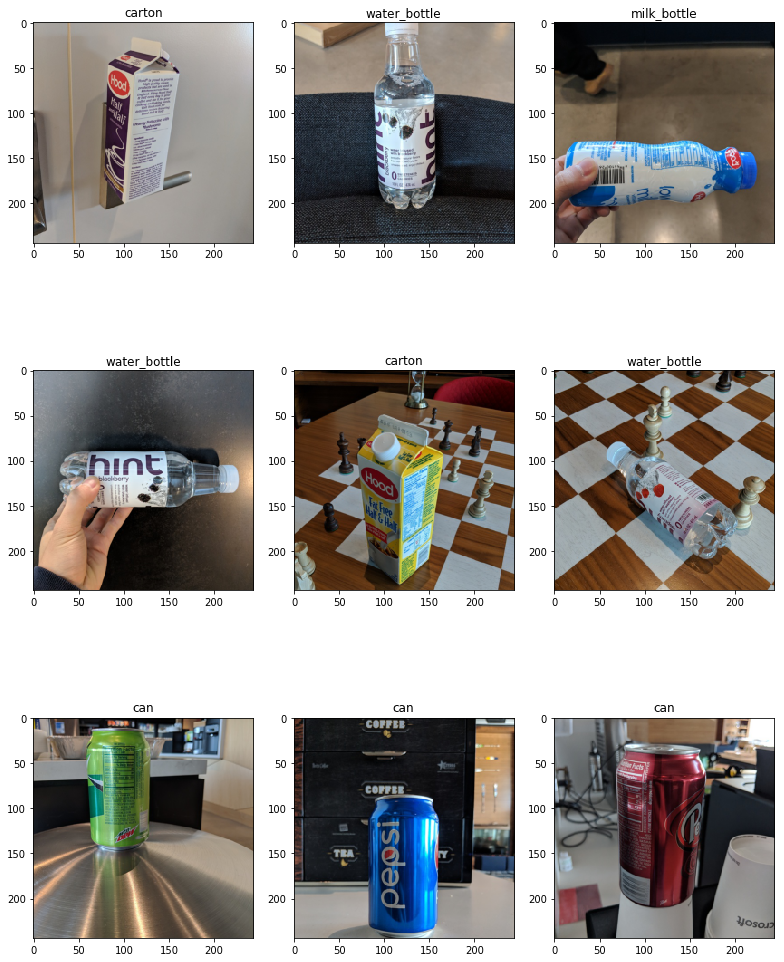

In [9]:
## Show sample data
data.show_batch(rows=3, figsize=(11,15), hide_axis=False) 

In [10]:
learner = cnn_learner(data, ARCHITECTURE, pretrained=True, metrics=accuracy)

In [11]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [12]:
# We to extract the features of the last BN layer
target_layer = learner.model[1][6]
target_layer

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [13]:
# Train the last layer
learner.fit_one_cycle(EPOCHS, LEARNING_RATE)

We use the featurizer hook `SaveFeatures` to save the features in the last layer. The operation `get_preds` computes the inference with the data.

In [14]:
featurizer = SaveFeatures(target_layer) 
learner.get_preds(data.train_ds)
features = featurizer.features
print(features.shape)

(134, 512)


In [15]:
img_path = [str(x) for x in list(data.train_ds.items)]

In [16]:
feature_dict = dict(zip(img_path, features))
print(len(feature_dict))

134


In [17]:
similars = compute_topk_similar(str(im1), feature_dict, distance=DISTANCE, top_k=TOP_K)
print(similars)

[('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/58.jpg', 0.0), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/36.jpg', 11.838206), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/56.jpg', 11.910216), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/50.jpg', 12.222944), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/39.jpg', 12.26477), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/57.jpg', 12.735534), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/61.jpg', 12.814874), ('/data/home/recocat/notebooks/miguel/ComputerVision/image_classification/data/fridgeObjects/carton/49.jpg', 12.827486), ('/data/home/recocat/notebooks/miguel/

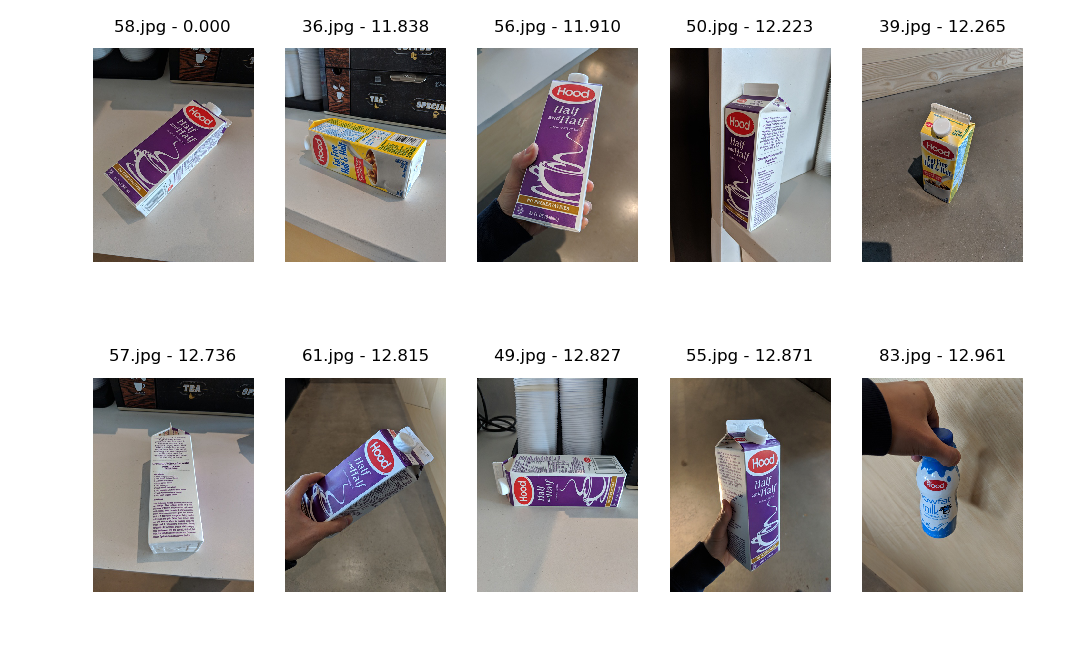

In [18]:
plot_similars(similars)

In [19]:
learner.unfreeze()

In [20]:
learner.fit_one_cycle(EPOCHS, LEARNING_RATE)

In [21]:
featurizer = SaveFeatures(target_layer) 
learner.get_preds(data.train_ds)
features = featurizer.features
print(features.shape)

(134, 512)


In [22]:
feature_dict2 = dict(zip(img_path, features))
print(len(feature_dict2))

134


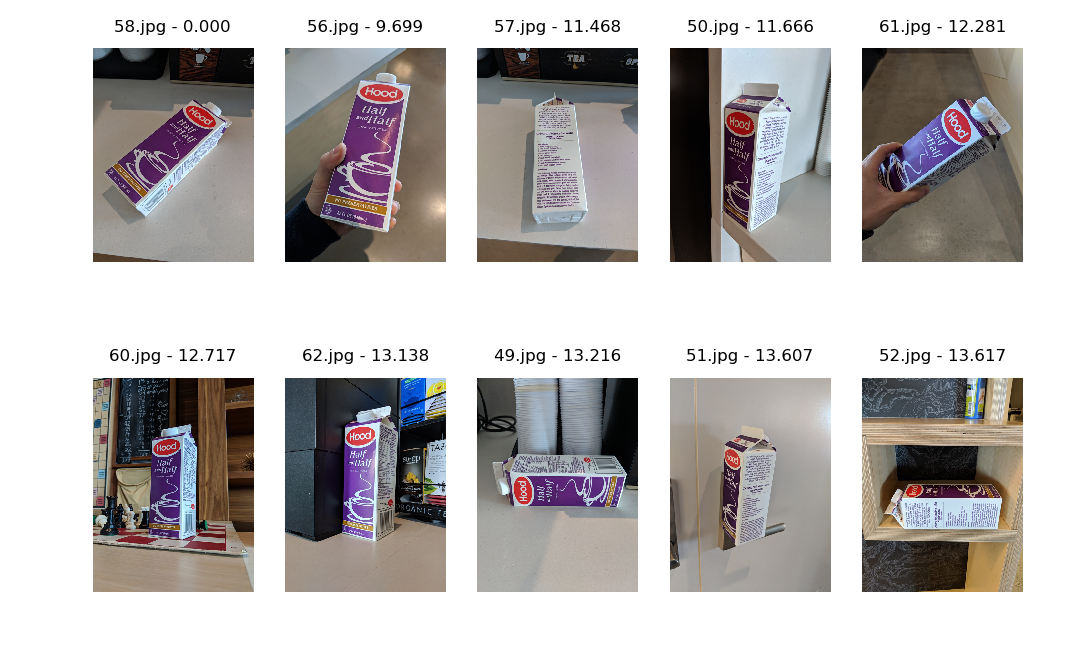

In [23]:
similars = compute_topk_similar(str(im1), feature_dict2, distance=DISTANCE, top_k=TOP_K)
plot_similars(similars)